# **Ajustar Anchura** 

Esta línea hace que se ajuste la anchura del notebook, por defecto la ajusta a un 92%

In [1]:
# Permite ajustar la anchura de la parte útil de la libreta (reduce los márgenes)
from IPython.display import display, HTML
display(HTML("<style>.container{ width:92% }</style>"))

# **Descargar Dependencias**

Estos son los elementos que se tienen que descargar para un uso adecuado de todo el notebook. 

In [ ]:
# !pip install swig
# !pip install wrds
# !pip install pyportfolioopt
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git
# !pip install yfinance
# !pip install pandas_market_calendars

# **Se importan las librerías**

In [33]:
import pandas as pd
import numpy as np
import datetime
import yfinance as yf

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl import config_tickers
from finrl.config import INDICATORS

import itertools

# 2. Separar en entrenamiento y prueba
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    f1_score
)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.utils import class_weight
from sklearn.metrics import classification_report, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

# **Se descargan los datos históricos**

In [3]:
# IMPORTANTE: Las fechas deben seguir el formato 'año/mes/día' (YYYY-MM-DD)
# Estas fechas delimitan el periodo de tiempo del que se descargarán los datos históricos
START_DATE = '2024-01-01'   # Fecha de inicio del análisis
END_DATE = '2025-03-04'     # Fecha de fin del análisis

# Lista de símbolos (tickers) de las acciones que se analizarán
# Estos corresponden a empresas cotizadas en bolsa como Moderna, Nvidia, Uber, etc.
symbols = [
    "MRNA",  # Moderna Inc.
    "NVDA",  # Nvidia Corp.
    "UBER",  # Uber Technologies Inc.
    "ASML",  # ASML Holding N.V.
    "AMZN",  # Amazon.com Inc.
    "AAPL"   # Apple Inc.
]

# Usamos el módulo YahooDownloader de FinRL para descargar datos históricos de acciones
# Se especifica el rango de fechas y la lista de símbolos (acciones) definidos previamente
data = YahooDownloader(
    start_date = START_DATE,   # Fecha de inicio del periodo de análisis
    end_date = END_DATE,       # Fecha de fin del periodo de análisis
    ticker_list = symbols      # Lista de acciones a descargar (AAPL, AMZN, etc.)
).fetch_data()                 # Ejecuta la descarga y devuelve un DataFrame con los datos

YF deprecation warning: set proxy via new config function: yf.set_config(proxy=proxy)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (1752, 8)


# **Extracción de Indicadores Técnicos y Reconstrucción de la Estructura Temporal**

### 1. Extracción de Indicadores Técnicos

Después de descargar los datos históricos de precios para varias acciones, se aplica un proceso de **ingeniería de características** para enriquecer el conjunto de datos con variables útiles para el modelo de aprendizaje automatizado.

Para esto, se utiliza el módulo `FeatureEngineer` de la biblioteca FinRL. Este módulo permite calcular automáticamente varios **indicadores técnicos**, que son ampliamente utilizados en el análisis técnico del mercado bursátil. Estos indicadores ayudan a capturar tendencias, momentum y señales de sobrecompra o sobreventa en los precios.

Entre los indicadores extraídos se encuentran:

- **RSI (Relative Strength Index)**
- **MACD (Moving Average Convergence Divergence)**
- **Bollinger Bands**
- **Medias móviles (SMA, EMA)**
- **CCI, DX, y más**

Además, se incluyen variables adicionales como:

- **VIX**: índice de volatilidad implícita del mercado, útil para medir el "miedo" del mercado.
- **Turbulence**: una medida del comportamiento anómalo del mercado basada en desviaciones multivariadas.

Estos indicadores se calculan para cada acción de forma individual y se agregan como nuevas columnas al DataFrame resultante (`processed`).

---

### 2. Reconstrucción de la estructura fecha × acción

Una vez que se tienen los indicadores técnicos, se realiza un paso adicional: **reconstruir la estructura completa del conjunto de datos**, garantizando que todas las combinaciones posibles de fechas y acciones estén presentes.

#### ¿Por qué se hace esto?

En el mundo real, no todas las acciones tienen datos disponibles para todas las fechas (por ejemplo, por días festivos, suspensiones de cotización o errores en la descarga). Para asegurar que el conjunto de datos sea consistente y estructurado (especialmente útil para modelos temporales), se realiza lo siguiente:

- Se genera una lista completa de fechas entre la mínima y máxima fecha observada.
- Se toma la lista de acciones (tickers) presentes en el conjunto de datos.
- Se calcula el **producto cartesiano** de fechas × acciones, creando todas las combinaciones posibles.
- Este nuevo DataFrame se fusiona con los datos procesados originales para **rellenar los valores existentes** y dejar explícitos los faltantes.
- Finalmente, se filtran las fechas que realmente ocurrieron en el mercado para evitar incluir días como fines de semana o festivos.

Este paso garantiza que el conjunto de datos tenga una estructura rectangular y ordenada, lo cual es especialmente útil para la fase de modelado.

---


In [4]:
# Creamos un objeto FeatureEngineer para calcular automáticamente indicadores técnicos
fe = FeatureEngineer(
    use_technical_indicator=True,        # Activamos el cálculo de indicadores técnicos clásicos (RSI, MACD, etc.)
    tech_indicator_list=INDICATORS,      # Usamos la lista predefinida de indicadores de FinRL
    use_vix=True,                        # Incluye el índice VIX (volatilidad implícita del mercado)
    use_turbulence=True,                 # Incluye la medida de turbulencia financiera
    user_defined_feature=False           # No se agregan indicadores personalizados por ahora
)

# Aplicamos el preprocesamiento sobre el DataFrame descargado ('data') para generar nuevas columnas con indicadores
processed = fe.preprocess_data(data)

# --- Reconstruimos la estructura completa fecha × acción para evitar combinaciones faltantes ---

# Obtenemos la lista única de tickers (acciones)
list_ticker = processed["tic"].unique().tolist()

# Creamos una lista de fechas entre la mínima y máxima fecha disponibles en el dataset
list_date = list(pd.date_range(processed['date'].min(), processed['date'].max()).astype(str))

# Generamos todas las combinaciones posibles de (fecha, ticker)
combination = list(itertools.product(list_date, list_ticker))

# Creamos un nuevo DataFrame con todas las combinaciones posibles (fecha, acción)
# Luego hacemos un left join con los datos procesados para rellenar los datos existentes
processed_full = pd.DataFrame(combination, columns=["date", "tic"]).merge(
    processed, on=["date", "tic"], how="left"
)

# Filtramos para conservar solo las fechas que realmente estaban en los datos originales
# Esto evita que aparezcan fechas inexistentes (por ejemplo, fines de semana o días festivos)
processed_full = processed_full[processed_full['date'].isin(processed['date'])]

# Ordenamos los datos primero por 'tic' (símbolo de la acción) y luego por 'date'
# Esto es necesario para aplicar el rellenado hacia adelante (forward fill) correctamente dentro de cada acción
processed_full = processed_full.sort_values(['tic', 'date'])

# Rellenamos los valores faltantes con el último valor válido conocido hacia adelante (forward fill)
# Esto es útil porque algunos indicadores técnicos no tienen valor en los primeros días y así evitamos NaNs
processed_full = processed_full = processed_full.ffill()

# Eliminamos cualquier fila que aún tenga valores faltantes después del rellenado
# Esto suele ocurrir en los primeros días de cada acción, donde no hay valores previos para propagar
processed_full = processed_full.dropna()


#OPCIONAL: Visualizar la data
processed_full.head(5)

Successfully added technical indicators


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (291, 8)
Successfully added vix
Successfully added turbulence index


,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2024-01-02,AAPL,184.290405,187.070052,182.553128,185.789422,82488700.0,1.0,0.000000,185.551913,181.649015,0.000000,-66.666667,100.000000,184.290405,184.290405,13.20,0.0
6,2024-01-03,AAPL,182.910522,184.528677,182.096477,182.880742,58414500.0,2.0,-0.030959,185.551913,181.649015,0.000000,-66.666667,100.000000,183.600464,183.600464,14.04,0.0
12,2024-01-04,AAPL,180.587555,181.758969,179.565044,180.825800,71983600.0,3.0,-0.111483,186.338830,178.853492,0.000000,-100.000000,100.000000,182.596161,182.596161,14.13,0.0
18,2024-01-05,AAPL,179.862839,181.431354,178.860187,180.666963,62303300.0,4.0,-0.171540,186.012761,177.812900,0.000000,-77.623425,100.000000,181.912830,181.912830,13.35,0.0
36,2024-01-08,AAPL,184.210999,184.250716,180.180517,180.766224,59144500.0,0.0,-0.027540,186.475187,178.269741,51.361197,26.023092,7.073258,182.372464,182.372464,13.08,0.0


# **Cálculo y Etiquetado de la Volatilidad**

### Parte 1: Cálculo de la Volatilidad de 5 Días

La volatilidad es una medida de qué tanto varían los precios de una acción en un periodo de tiempo. En este caso, la calculamos como la **desviación estándar de los rendimientos diarios** en una ventana móvil de 5 días.

#### ¿Qué se hace?

- Se agrupan los datos por acción (`tic`), ya que la volatilidad debe calcularse de forma independiente para cada activo.
- Se aplica una **ventana móvil de 5 días** sobre la columna `return`, que representa el rendimiento diario.
- Dentro de esa ventana, se calcula la **desviación estándar**, lo cual nos da una estimación local de la volatilidad.
- El resultado se asigna como una nueva columna llamada `volatility_5d`.

#### ¿Por qué usar desviación estándar?

La desviación estándar es una medida clásica de **dispersión estadística**. Cuando los rendimientos de una acción fluctúan mucho en pocos días, la desviación estándar será alta. Por eso, se utiliza como una buena aproximación de la volatilidad en análisis financiero.

---

### Parte 2: Etiquetado de Días con "Alta Volatilidad"

Para usar modelos de clasificación, necesitamos transformar la volatilidad continua en una variable binaria. Lo hacemos creando una etiqueta que indique si un día tiene o no **alta volatilidad**.

#### ¿Qué se hace?

- Se agrupan los datos por acción (`tic`), ya que cada acción puede tener un nivel típico de volatilidad distinto.
- Se calcula el **percentil 75** (también llamado cuartil superior) de la columna `volatility_5d` para cada acción.
- Este valor actúa como un **umbral dinámico**: representa qué tan volátil debe ser un día para ser considerado "alto" en el contexto de esa acción.
- Para cada fila, se compara la volatilidad observada con ese umbral:
  - Si la volatilidad es mayor al percentil 75 → se etiqueta como `1` (alta volatilidad).
  - Si es menor o igual → se etiqueta como `0` (baja o normal volatilidad).
- El resultado se almacena en una nueva columna llamada `volatilidad_alta`.

---

#### ¿Qué es el percentil 75 y por qué se usa?

El percentil 75 es el valor por debajo del cual se encuentra el 75% de los datos. En este caso, representa un umbral de volatilidad "alta" relativo al comportamiento típico de cada acción. Si la volatilidad de un día supera este valor, se considera un evento inusualmente volátil. Esta estrategia permite adaptar el criterio de alta volatilidad a cada acción, en lugar de usar un valor fijo para todas.


In [5]:
# 1. Ordenamos por acción y fecha
processed_full = processed_full.sort_values(['tic', 'date'])

# 2. Calculamos el rendimiento diario por acción
processed_full['return'] = processed_full.groupby('tic')['close'].pct_change()

# 3. Calculamos la volatilidad como desviación estándar de 5 días sobre los rendimientos
processed_full['volatility_5d'] = processed_full.groupby('tic')['return'].rolling(5).std().reset_index(0, drop=True)

# 4. Etiquetamos los días con volatilidad alta (top 30% por acción usando percentil 70)
def etiquetar_volatilidad(df, column='volatility_5d', percentil=0.65):
    umbrales = df.groupby('tic')[column].transform(lambda x: x.quantile(percentil))
    df['volatilidad_alta'] = (df[column] > umbrales).astype(int)
    return df

processed_full = etiquetar_volatilidad(processed_full, percentil=0.70)

# 5. Eliminamos filas con valores faltantes
processed_full = processed_full.dropna()

processed_full

,date,tic,close,high,low,open,volume,day,macd,boll_ub,...,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence,return,volatility_5d,volatilidad_alta
42,2024-01-09,AAPL,183.794052,183.803974,181.401569,182.582920,42841800.0,1.0,0.041713,186.458180,...,48.871269,29.331090,7.073258,182.609395,182.609395,12.760000,0.000000,-0.002263,0.014335,0
48,2024-01-10,AAPL,184.836441,185.044906,182.582939,183.009821,46792900.0,2.0,0.132629,186.823494,...,54.567540,76.254893,13.208758,182.927545,182.927545,12.690000,0.000000,0.005672,0.013924,0
54,2024-01-11,AAPL,184.240784,185.690176,182.285104,185.183874,49128400.0,3.0,0.163129,186.816263,...,51.195830,66.900169,21.476506,183.091700,183.091700,12.440000,0.000000,-0.003223,0.011889,0
60,2024-01-12,AAPL,184.568375,185.382421,183.843686,184.707356,40444700.0,4.0,0.198020,186.876198,...,52.853227,85.517246,21.476506,183.255775,183.255775,12.700000,0.000000,0.001778,0.011165,0
84,2024-01-16,AAPL,182.295029,182.920438,179.614645,180.835714,65603000.0,1.0,0.102792,186.626730,...,42.493488,-66.785421,29.102461,183.159700,183.159700,13.840000,0.000000,-0.012317,0.006729,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2519,2025-02-24,UBER,76.419998,78.879997,74.849998,78.650002,24368400.0,0.0,3.449048,86.061833,...,56.159591,65.676325,7.593468,71.628999,68.240166,18.980000,4.777463,-0.031309,0.023722,1
2525,2025-02-25,UBER,74.949997,76.370003,73.529999,76.360001,19559200.0,1.0,3.006083,86.140179,...,54.305930,39.701343,12.923284,71.928332,68.265666,19.430000,1.501329,-0.019236,0.014634,0
2531,2025-02-26,UBER,75.870003,76.489998,75.309998,75.330002,10328900.0,2.0,2.698164,86.198854,...,55.261977,47.506516,12.293895,72.267332,68.337499,19.100000,6.419838,0.012275,0.019213,0
2537,2025-02-27,UBER,74.209999,77.690002,73.709999,75.949997,22535900.0,3.0,2.293746,85.983300,...,53.184914,35.376200,18.748735,72.579666,68.380666,21.129999,9.438051,-0.021880,0.017570,0


# **Descripción de las columnas del dataset final (`data_para_modelo.csv`)**

A continuación se describen brevemente las columnas del conjunto de datos que se utilizará para entrenar los modelos de clasificación:

- **close**: Precio de cierre de la acción en el día correspondiente.
- **high**: Precio más alto alcanzado por la acción durante el día.
- **low**: Precio más bajo alcanzado por la acción durante el día.
- **open**: Precio de apertura de la acción en ese día.
- **volume**: Volumen de operaciones (cantidad de acciones intercambiadas en el día).
- **day**: Día de la semana representado como número (0 = lunes, 6 = domingo).

### Indicadores técnicos (features extraídas automáticamente):
- **macd**: Media móvil de convergencia/divergencia, indicador de momentum.
- **boll_ub** / **boll_lb**: Bandas de Bollinger superior e inferior, usadas para detectar sobrecompra o sobreventa.
- **rsi_30**: Índice de fuerza relativa (RSI) con ventana de 30 días.
- **cci_30**: Commodity Channel Index, mide la variación del precio respecto a su media.
- **dx_30**: Directional Movement Index, evalúa la fuerza de una tendencia.
- **close_30_sma** / **close_60_sma**: Medias móviles simples del precio de cierre en ventanas de 30 y 60 días.

### Etiqueta (target):
- **volatilidad_alta**: Variable binaria que indica si el día fue clasificado como de alta volatilidad (`1`) o no (`0`), calculado con base en el percentil 75 de la volatilidad histórica por acción.

---


# Modelos Clásicos de Clasificación Evaluados

Para clasificar los días con alta volatilidad se probaron cinco modelos clásicos de aprendizaje supervisado, cada uno representando un enfoque distinto:

- **Random Forest**: Ensamble de árboles, robusto y eficaz con datos tabulares. Resiste bien el sobreajuste.

- **Regresión Logística**: Modelo lineal e interpretable, usado como *benchmark* básico.

- **XGBoost**: Técnica avanzada de *boosting*, capaz de capturar relaciones no lineales y manejar desbalanceo.

- **SVM**: Modelo que busca la mejor frontera entre clases; útil con *kernels* para capturar relaciones complejas.

- **KNN**: Clasificador basado en distancia, simple pero útil como contraste frente a modelos más estructurados.

In [6]:
def evaluar_modelo(modelo, nombre, X_train, y_train, X_test, y_test, mostrar_roc=True):
    """
    Entrena y evalúa un modelo de clasificación.

    Retorna:
        accuracy, f1_score, auc (si aplica, si no retorna None)
    """
    # Entrenamiento
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)

    # F1-score para la clase 1 (alta volatilidad)
    f1 = f1_score(y_test, y_pred, pos_label=1)

    # AUC (solo si el modelo tiene predict_proba y se solicita)
    auc = None
    if mostrar_roc and hasattr(modelo, "predict_proba"):
        y_proba = modelo.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)

    return acc, f1, auc

# Motivación de los Indicadores Utilizados para el Entrenamiento

En este trabajo buscamos predecir si un día determinado tendrá alta volatilidad en el precio de una acción. Para ello, seleccionamos diferentes grupos de variables que capturan distintos aspectos del comportamiento del mercado. A continuación se justifica cada grupo evaluado:

---

### 1. Precios del activo (`open`, `close`, `high`, `low`)

Los precios reflejan la información más inmediata del mercado:

- `open` y `close` representan el precio inicial y final del día.
- `high` y `low` indican los extremos de volatilidad intradía.

Estos datos permiten detectar movimientos bruscos en precios que pueden correlacionarse con futuros periodos de alta volatilidad.

---

### 2. Indicadores técnicos

Los indicadores técnicos como `RSI`, `MACD`, `CCI`, `Bollinger Bands`, `DX`, etc., son comúnmente usados en el análisis técnico para detectar:

- Tendencias (por ejemplo, `MACD`),
- Niveles de sobrecompra o sobreventa (por ejemplo, `RSI`, `CCI`),
- Cambios de dirección del mercado.

Estos indicadores agregan una capa de interpretación sobre los precios, ayudando a anticipar periodos de alta volatilidad.

---

### 3. Indicadores de riesgo de mercado (`VIX`, `turbulence`)

- `VIX` es un índice que mide la volatilidad implícita esperada del mercado. Es un indicador reconocido de “miedo” en los inversionistas.
- `turbulence` mide la inestabilidad o comportamiento anómalo del mercado comparado con su comportamiento histórico.

Ambos son indicadores exógenos que pueden influir fuertemente en la volatilidad individual de una acción.

---

### 4. Evaluación de todas las combinaciones

Para comprender el aporte predictivo de cada grupo de variables, se evaluaron las siguientes configuraciones:

| Combinación de variables     | Descripción                                                                 |
|------------------------------|-----------------------------------------------------------------------------|
| Todas las variables          | Incluye precios, indicadores técnicos y de riesgo                          |
| Solo indicadores técnicos    | MACD, RSI, CCI, Bollinger Bands, DX, medias móviles                        |
| Solo precios                 | Precios diarios: `open`, `close`, `high`, `low`                            |
| Solo VIX + Turbulence        | Indicadores exógenos de riesgo e inestabilidad del mercado                 |

Estas combinaciones se entrenaron y evaluaron utilizando cinco modelos de clasificación distintos para obtener una comparación robusta.

---

### 5. Selección Evolutiva de Características

Para optimizar aún más el rendimiento del modelo, se implementó una estrategia basada en un **Algoritmo Genético (GA)** con el fin de seleccionar automáticamente un subconjunto óptimo de características entre todas las disponibles.

Esta estrategia permitió:

- Explorar de forma inteligente el espacio de combinaciones posibles.
- Combinar buenas soluciones parciales mediante operadores de cruce y mutación.
- Identificar subconjuntos de variables que maximizan la precisión promedio en múltiples clasificadores (Random Forest, Regresión Logística, XGBoost, SVM y KNN).

La selección evolutiva no solo ayudó a reducir la dimensionalidad del problema, sino que también mejoró el desempeño en algunos casos respecto a configuraciones manuales, y permitió establecer una base sólida para el entrenamiento de modelos más complejos como las redes neuronales recurrentes (RNN).

### Partición del conjunto de datos

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# =========================
# Helper para aplicar One-Hot a 'day'
# =========================
def aplicar_one_hot(df, incluir_day=True):
    df = df.copy()
    if incluir_day and 'day' in df.columns:
        df = pd.get_dummies(df, columns=['day'], prefix='day')
    return df

# =========================
# Todas las variables (con 'day' en One-Hot)
# =========================
columnas_excluir = ['date', 'tic', 'volatilidad_alta']
columnas_modelo = [col for col in processed_full.columns if col not in columnas_excluir]

X_todas = processed_full[columnas_modelo].copy()
X_todas = aplicar_one_hot(X_todas)  # One-Hot para 'day'
y_todas = processed_full['volatilidad_alta']

X_train, X_test, y_train, y_test = train_test_split(
    X_todas, y_todas, test_size=0.2, shuffle=False
)

scaler_todas = StandardScaler()
X_train_scaled = scaler_todas.fit_transform(X_train)
X_test_scaled = scaler_todas.transform(X_test)

# =========================
# Indicadores Técnicos (con 'day')
# =========================
columnas_indicadores = [
    "macd", "boll_ub", "boll_lb", "rsi_30", "cci_30", "dx_30",
    "close_30_sma", "close_60_sma", "day"  # incluimos explícitamente 'day'
]
df_indicadores = processed_full[columnas_indicadores + ["volatilidad_alta"]]
df_indicadores = aplicar_one_hot(df_indicadores)

X_indicadores = df_indicadores.drop(columns=['volatilidad_alta'])
y_indicadores = df_indicadores['volatilidad_alta']

X_train_ind, X_test_ind, y_train_ind, y_test_ind = train_test_split(
    X_indicadores, y_indicadores, test_size=0.2, shuffle=False
)

scaler_ind = StandardScaler()
X_train_ind_scaled = scaler_ind.fit_transform(X_train_ind)
X_test_ind_scaled = scaler_ind.transform(X_test_ind)

# =========================
# Solo Precios (con 'day')
# =========================
columnas_precios = ['open', 'close', 'high', 'low', 'day']
df_precios = processed_full[columnas_precios + ['volatilidad_alta']]
df_precios = aplicar_one_hot(df_precios)

X_precios = df_precios.drop(columns=['volatilidad_alta'])
y_precios = df_precios['volatilidad_alta']

X_train_precios, X_test_precios, y_train_precios, y_test_precios = train_test_split(
    X_precios, y_precios, test_size=0.2, shuffle=False
)

scaler_prec = StandardScaler()
X_train_precios_scaled = scaler_prec.fit_transform(X_train_precios)
X_test_precios_scaled = scaler_prec.transform(X_test_precios)

# =========================
# VIX + Turbulence (con 'day')
# =========================
columnas_vix_turb = ['vix', 'turbulence', 'day']
df_vix_turbulence = processed_full[columnas_vix_turb + ['volatilidad_alta']]
df_vix_turbulence = aplicar_one_hot(df_vix_turbulence)

X_vix_turbulence = df_vix_turbulence.drop(columns=['volatilidad_alta'])
y_vix_turbulence = df_vix_turbulence['volatilidad_alta']

X_train_vix_turb, X_test_vix_turb, y_train_vix_turb, y_test_vix_turb = train_test_split(
    X_vix_turbulence, y_vix_turbulence, test_size=0.2, shuffle=False
)

scaler_vix_turb = StandardScaler()
X_train_vix_turb_scaled = scaler_vix_turb.fit_transform(X_train_vix_turb)
X_test_vix_turb_scaled = scaler_vix_turb.transform(X_test_vix_turb)

### Evaluación de los modelos

In [8]:
# ===============================================================
# DEFINICIÓN DE CLASIFICADORES A EVALUAR
# ===============================================================

# Diccionario con cinco modelos clásicos de clasificación supervisada.
# Cada entrada tiene un nombre (para identificación en resultados) y su instancia.
clasificadores = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Regresión Logística": LogisticRegression(max_iter=500),
    "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss'),
    "SVM": SVC(probability=True, random_state=42),  # Se habilita probability para AUC
    "K-Nearest Neighbors": KNeighborsClassifier()
}

# ===============================================================
# CONJUNTOS DE DATOS A PROBAR
# ===============================================================

# Lista de diccionarios, cada uno representa una combinación de variables.
# Cada combinación contiene sus datos de entrenamiento y prueba (ya escalados).
conjuntos = [
    {
        "nombre": "Todas las variables",
        "X_train": X_train_scaled,
        "X_test": X_test_scaled,
        "y_train": y_train,
        "y_test": y_test
    },
    {
        "nombre": "Indicadores técnicos",
        "X_train": X_train_ind_scaled,
        "X_test": X_test_ind_scaled,
        "y_train": y_train_ind,
        "y_test": y_test_ind
    },
    {
        "nombre": "Solo precios",
        "X_train": X_train_precios_scaled,
        "X_test": X_test_precios_scaled,
        "y_train": y_train_precios,
        "y_test": y_test_precios
    },
    {
        "nombre": "VIX + Turbulence",
        "X_train": X_train_vix_turb_scaled,
        "X_test": X_test_vix_turb_scaled,
        "y_train": y_train_vix_turb,
        "y_test": y_test_vix_turb
    }
]

# ===============================================================
# EVALUACIÓN DE CADA MODELO SOBRE CADA CONJUNTO DE VARIABLES
# ===============================================================

# Lista donde se almacenarán los resultados promedio por combinación
resultados = []

# Iteramos sobre cada conjunto definido (por nombre y datos)
for conjunto in conjuntos:
    nombre_combo = conjunto["nombre"]
    X_train = conjunto["X_train"]
    X_test = conjunto["X_test"]
    y_train = conjunto["y_train"]
    y_test = conjunto["y_test"]

    # Lista para almacenar accuracy de cada modelo en esta combinación
    accuracies = []

    # Evaluamos cada modelo con la función definida previamente
    for nombre_modelo, modelo in clasificadores.items():
        acc, _, _ = evaluar_modelo(
            modelo,
            f"{nombre_modelo} ({nombre_combo})",
            X_train,
            y_train,
            X_test,
            y_test
        )
        accuracies.append(acc)

    # Promediamos las precisiones de todos los modelos sobre esta combinación
    promedio = np.mean(accuracies)

    # Guardamos el resultado
    resultados.append({
        "nombre": nombre_combo,
        "promedio": promedio
    })

    # Mostramos el resultado por consola
    print(f"Precisión promedio ({nombre_combo}): {promedio:.4f}")

Precisión promedio (Todas las variables): 0.8436
Precisión promedio (Indicadores técnicos): 0.7099
Precisión promedio (Solo precios): 0.7006
Precisión promedio (VIX + Turbulence): 0.6953


# Estrategia Evolutiva


Con el objetivo de mejorar la precisión en la clasificación de días con alta volatilidad, se implementó una estrategia basada en un Algoritmo Genético (GA) para seleccionar automáticamente el subconjunto óptimo de características entre todas las disponibles.

---

### Motivación

El número de posibles combinaciones de columnas crece exponencialmente, y probarlas manualmente no es factible. Además, no todas las variables aportan valor predictivo; algunas pueden introducir ruido o redundancia. El algoritmo genético permite:

- Explorar inteligentemente el espacio de búsqueda.
- Combinar buenas soluciones parciales.
- Identificar subconjuntos que maximizan la precisión promedio en múltiples modelos.

---

### Estrategia Evolutiva

#### 1. Codificación de Individuos

Cada individuo del algoritmo representa un subconjunto de columnas codificado como un vector binario:

- `1`: la columna está incluida.
- `0`: la columna está descartada.

#### 2. Función de Aptitud (Fitness)

Para cada subconjunto (individuo), se evalúa su rendimiento promedio usando cinco clasificadores:

- Random Forest
- Regresión Logística
- XGBoost
- SVM
- K-Nearest Neighbors

El valor de fitness es el promedio de *accuracy* entre estos modelos, evaluados en un conjunto de prueba fijo.

#### 3. Parámetros Utilizados

| Parámetro             | Valor                         |
|-----------------------|-------------------------------|
| Tamaño de población   | 10 a 40 individuos            |
| Número de generaciones| 5 a 30 generaciones           |
| Tasa de mutación      | 0.1 (10%)                     |
| Selección             | Mejores 50% por generación    |
| Cruce (crossover)     | 1 punto                       |
| Mutación              | Cambio de bits aleatorio      |

#### 4. Resultados

El algoritmo evolutivo fue capaz de:

- Identificar subconjuntos pequeños con buen rendimiento.
- Superar algunas configuraciones manuales.
- Adaptarse al conjunto completo de columnas, descartando automáticamente aquellas menos útiles.

---

### Ventajas

- Automatiza la búsqueda del mejor subconjunto de variables.
- Considera múltiples modelos simultáneamente.
- Reduce el riesgo de *overfitting* por selección manual.

---

In [ ]:
# 1) Definir df_model
df_model = processed_full.drop(columns=['date', 'tic', 'return', 'volatility_5d'])

# Aplicar One-Hot Encoding a 'day' si existe
if 'day' in df_model.columns:
    df_model = pd.get_dummies(df_model, columns=['day'], prefix='day')

# Asegurar que 'volatilidad_alta' esté al final
cols = [c for c in df_model.columns if c != 'volatilidad_alta'] + ['volatilidad_alta']
df_model = df_model[cols]

# 2) Separar X e y
X = df_model.drop(columns=['volatilidad_alta'])
y = df_model['volatilidad_alta']

# 3) División temporal
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# 4) Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5) Parámetros del GA
POP_SIZE = 10
N_GENERATIONS = 30
MUTATION_RATE = 0.1
N_FEATURES = X.shape[1]

# 6) Creación, mutación y cruce
def create_individual():
    return np.random.choice([0, 1], size=N_FEATURES)

def mutate(ind):
    m = ind.copy()
    for i in range(N_FEATURES):
        if np.random.rand() < MUTATION_RATE:
            m[i] = 1 - m[i]
    return m

def crossover(p1, p2):
    if N_FEATURES < 3:
        return p1.copy(), p2.copy()
    pt = np.random.randint(1, N_FEATURES-1)
    return (
        np.concatenate([p1[:pt], p2[pt:]]),
        np.concatenate([p2[:pt], p1[pt:]])
    )

# 7) Función de fitness
def fitness(ind):
    sel = np.where(ind == 1)[0]
    if len(sel) == 0:
        return 0
    Xtr, Xte = X_train_scaled[:, sel], X_test_scaled[:, sel]
    models = [
        RandomForestClassifier(random_state=42),
        LogisticRegression(max_iter=500),
        XGBClassifier(random_state=42, eval_metric='logloss'),
        SVC(probability=True, random_state=42),
        KNeighborsClassifier()
    ]
    scores = []
    for m in models:
        try:
            m.fit(Xtr, y_train)
            scores.append(m.score(Xte, y_test))
        except:
            scores.append(0)
    return np.mean(scores)

# 8) Inicializar población
pop = [create_individual() for _ in range(POP_SIZE)]

# 9) Evolución
for gen in range(N_GENERATIONS):
    fits = [fitness(ind) for ind in pop]
    ranked = sorted(zip(pop, fits), key=lambda x: x[1], reverse=True)
    survivors = [ind for ind, _ in ranked[:POP_SIZE // 2]]
    
    # Imprimir cada 10 generaciones
    if (gen + 1) % 10 == 0 or gen == 0 or gen == N_GENERATIONS - 1:
        print(f"Generación {gen+1}: Mejor accuracy = {ranked[0][1]:.4f}")
    
    next_pop = survivors.copy()
    while len(next_pop) < POP_SIZE:
        a, b = random.sample(survivors, 2)
        c1, c2 = crossover(a, b)
        next_pop += [mutate(c1), mutate(c2)]
    pop = next_pop[:POP_SIZE]


# 10) Mejor solución final
final_scores = [fitness(ind) for ind in pop]
best_idx = np.argmax(final_scores)
best_ind = pop[best_idx]
best_acc = final_scores[best_idx]
best_features = X.columns[best_ind == 1].tolist()

print("\n Mejor Accuracy Promedio GA:", best_acc)
print(" Columnas Seleccionadas:", best_features)

# **RED RNN**

## Construcción de Secuencias para RNN

Con el objetivo de entrenar una Red Neuronal Recurrente (RNN), transformamos nuestro dataset en una estructura de secuencias temporales. Cada secuencia agrupa **5 días consecutivos** de datos de una misma acción (`tic`) y se utiliza para predecir si el **último día** de la secuencia tiene una **alta volatilidad** (`volatilidad_alta = 1`) o no.

### Proceso realizado:

- Se generaron las secuencias **por acción**, respetando el orden cronológico de cada una.
- Cada secuencia contiene los valores de los indicadores técnicos y precios durante 5 días.
- La etiqueta (`y`) asociada a cada secuencia corresponde al valor de `volatilidad_alta` del día inmediatamente **posterior** a la secuencia.
- Se excluyeron las columnas `date`, `tic` y `volatilidad_alta` del input `X`, ya que no son características útiles como entrada directa a la red.

### Resultados obtenidos:

- Total de secuencias generadas: **1686**
- Dimensiones de `X_rnn`: `(1686, 5, 18)`
  - 1686 ejemplos
  - 5 pasos de tiempo por secuencia
  - 18 características por paso de tiempo
- Dimensiones de `y_rnn`: `(1686,)`
  - Cada etiqueta es `0` o `1`, indicando si el día siguiente a la secuencia tuvo alta volatilidad.

Este formato es el ideal para alimentar una arquitectura LSTM, GRU o RNN simple en frameworks como PyTorch o TensorFlow/Keras.


## Ejemplo de cómo se construyen las secuencias para una RNN

Cuando usamos una **RNN (Red Neuronal Recurrente)**, no alimentamos datos individuales, sino **secuencias de días consecutivos**. En este caso, usamos una **ventana de 5 días** (`sequence_length = 5`) y queremos predecir si el **día siguiente tendrá alta volatilidad** (`volatilidad_alta = 1`).

---

### Datos originales (simplificados)

```text
date        close   RSI   volumen   volatilidad_alta
2024-01-01   100     30    1.5M           0
2024-01-02   102     35    1.6M           0
2024-01-03   105     40    1.4M           1
2024-01-04   103     38    1.7M           0
2024-01-05   106     45    1.6M           1
2024-01-06   107     46    1.8M           0
```

---

### Construcción de secuencias

Con `sequence_length = 5`, generamos una **secuencia de entrada** (`X[0]`) a partir de los primeros 5 días:

```python
X[0] = [
    [100, 30, 1.5M],
    [102, 35, 1.6M],
    [105, 40, 1.4M],
    [103, 38, 1.7M],
    [106, 45, 1.6M]
]
```

La **etiqueta** correspondiente (`y[0]`) será el valor de `volatilidad_alta` del **día siguiente** (2024-01-06):

```python
y[0] = 0
```

---

### ¿Cómo se genera el resto del dataset?

Este proceso se repite de manera **deslizante** a lo largo del dataset para generar muchas secuencias con sus respectivas etiquetas.

---

### Formato final del conjunto de datos

Cada entrada tiene forma:

```text
(secuencia, características) = (5, 18)
```

Donde:

- `5` = número de días en la ventana,
- `18` = número de características financieras por día.

---

Este formato es ideal para modelos de series de tiempo como **RNNs**, **LSTMs** o **GRUs**.

In [30]:
from sklearn.metrics import f1_score

for thresh in np.arange(0.40, 0.51, 0.01):
    y_pred = (y_pred_probs > thresh).astype(int).flatten()
    f1 = f1_score(y_test_rnn, y_pred)
    print(f"Umbral {thresh:.2f}: F1 = {f1:.3f}")

Umbral 0.40: F1 = 0.487
Umbral 0.41: F1 = 0.479
Umbral 0.42: F1 = 0.482
Umbral 0.43: F1 = 0.482
Umbral 0.44: F1 = 0.480
Umbral 0.45: F1 = 0.478
Umbral 0.46: F1 = 0.473
Umbral 0.47: F1 = 0.477
Umbral 0.48: F1 = 0.477
Umbral 0.49: F1 = 0.476
Umbral 0.50: F1 = 0.471


In [ ]:
import numpy as np

percentiles = [60, 65, 70, 75, 80, 85, 90]

for p in percentiles:
    labels = processed_full.groupby('tic')['volatility_5d'].transform(lambda x: (x > np.percentile(x, p)).astype(int))
    ratio = labels.mean()
    print(f"Percentil {p}: proporción de alta volatilidad = {ratio:.3f}")

In [34]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# ========================
# 1. Preprocesamiento
# ========================

# Elimina columnas no deseadas
df_model = processed_full.drop(columns=['return', 'volatility_5d'])

# Aplica One-Hot Encoding a 'day' si está presente
if 'day' in df_model.columns:
    df_model = pd.get_dummies(df_model, columns=['day'], prefix='day')

# Escalar todas las columnas numéricas excepto 'volatilidad_alta'
cols_excluir = ['date', 'tic', 'volatilidad_alta']
features = [col for col in df_model.columns if col not in cols_excluir]
scaler_rnn = StandardScaler()
df_model[features] = scaler_rnn.fit_transform(df_model[features])

# ========================
# 2. Construcción de Secuencias
# ========================

def construir_secuencias_por_accion(df, sequence_length=5):
    X_seq, y_seq = [], []
    tics = df['tic'].unique()
    columnas_excluir = ['date', 'tic', 'volatilidad_alta']
    feature_cols = [col for col in df.columns if col not in columnas_excluir]

    for tic in tics:
        df_tic = df[df['tic'] == tic].sort_values('date').reset_index(drop=True)
        for i in range(sequence_length, len(df_tic)):
            secuencia = df_tic.loc[i-sequence_length:i-1, feature_cols].values
            etiqueta = df_tic.loc[i, 'volatilidad_alta']
            X_seq.append(secuencia)
            y_seq.append(etiqueta)

    return np.array(X_seq), np.array(y_seq)

# Genera las secuencias
X_rnn, y_rnn = construir_secuencias_por_accion(df_model, sequence_length=5)

# ========================
# 3. División de datos
# ========================
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(
    X_rnn, y_rnn, test_size=0.2, shuffle=False
)

Entrenando modelo SIN pesos de clase
Epoch 1/30


/home/danirm/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6150 - loss: 0.6652 - val_accuracy: 0.6953 - val_loss: 0.6120
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7069 - loss: 0.6095 - val_accuracy: 0.6775 - val_loss: 0.6329
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7217 - loss: 0.5823 - val_accuracy: 0.6716 - val_loss: 0.6271
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6981 - loss: 0.5954 - val_accuracy: 0.6716 - val_loss: 0.6337
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7110 - loss: 0.5889 - val_accuracy: 0.6598 - val_loss: 0.6464
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

📊 Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.71      0.90      0.80       238
           1       0.38      0.14      0.20       100

    accuracy                           0.68       338
   macro avg       0.55      0.52      0.50       338
weighted avg       0.61      0.68  

/home/danirm/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5071 - loss: 0.6997 - val_accuracy: 0.6036 - val_loss: 0.6728
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5530 - loss: 0.6829 - val_accuracy: 0.5947 - val_loss: 0.6995
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6188 - loss: 0.6559 - val_accuracy: 0.6154 - val_loss: 0.7017
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6281 - loss: 0.6492 - val_accuracy: 0.6124 - val_loss: 0.7106
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6564 - loss: 0.6284 - val_accuracy: 0.6243 - val_loss: 0.7162
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

📊 Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       238
           1       0.30      1.00      0.46       100

    accuracy                           0.30       338
   macro avg       0.15      0.50      0.23       338
weighted avg       0.09      0.30  

/home/danirm/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/danirm/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/danirm/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


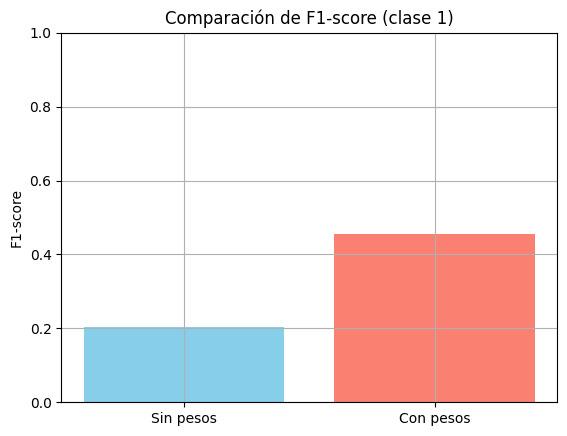

In [35]:
# ========================
# 1. Construcción del modelo RNN
# ========================
def crear_modelo(input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(32))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ========================
# 2. Entrenamiento y evaluación
# ========================
def entrenar_y_evaluar(X_train, y_train, X_test, y_test, usar_pesos=False, umbral=0.4):
    model = crear_modelo((X_train.shape[1], X_train.shape[2]))

    # Early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

    if usar_pesos:
        pesos = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(y_train),
            y=y_train
        )
        class_weight_dict = dict(enumerate(pesos))
        print("Entrenando modelo con pesos de clase:", class_weight_dict)
    else:
        class_weight_dict = None
        print("Entrenando modelo SIN pesos de clase")

    # Entrenar
    history = model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=32,
        validation_data=(X_test, y_test),
        class_weight=class_weight_dict,
        callbacks=[early_stop],
        verbose=1
    )

    # Evaluar
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs > umbral).astype(int).flatten()

    print("\n📊 Reporte de clasificación:")
    print(classification_report(y_test, y_pred))
    f1 = f1_score(y_test, y_pred, pos_label=1)
    print(f"F1-score (clase 1): {f1:.4f}")

    return f1, history

# ========================
# 3. Ejecutar ambas variantes
# ========================
f1_base, hist_base = entrenar_y_evaluar(X_train_rnn, y_train_rnn, X_test_rnn, y_test_rnn, usar_pesos=False)
f1_pesos, hist_pesos = entrenar_y_evaluar(X_train_rnn, y_train_rnn, X_test_rnn, y_test_rnn, usar_pesos=True)

# ========================
# 4. Comparar F1-score
# ========================
plt.bar(["Sin pesos", "Con pesos"], [f1_base, f1_pesos], color=['skyblue', 'salmon'])
plt.title("Comparación de F1-score (clase 1)")
plt.ylabel("F1-score")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

In [37]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# === 1. Preprocesamiento ===
def preparar_datos(processed_full, sequence_length=5):
    df_model = processed_full.drop(columns=['return', 'volatility_5d'])

    if 'day' in df_model.columns:
        df_model = pd.get_dummies(df_model, columns=['day'], prefix='day')

    cols_excluir = ['date', 'tic', 'volatilidad_alta']
    features = [col for col in df_model.columns if col not in cols_excluir]
    scaler = StandardScaler()
    df_model[features] = scaler.fit_transform(df_model[features])

    X, y = [], []
    for tic in df_model['tic'].unique():
        df_tic = df_model[df_model['tic'] == tic].sort_values('date').reset_index(drop=True)
        for i in range(sequence_length, len(df_tic)):
            secuencia = df_tic.loc[i-sequence_length:i-1, features].values
            etiqueta = df_tic.loc[i, 'volatilidad_alta']
            X.append(secuencia)
            y.append(etiqueta)
    return np.array(X), np.array(y)

# === 2. Construcción del modelo ===
def crear_modelo(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# === 3. Entrenamiento y evaluación ===
def entrenar_y_evaluar_modelo(X_train, y_train, X_test, y_test, usar_pesos=False):
    model = crear_modelo((X_train.shape[1], X_train.shape[2]))
    callbacks = [EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)]
    fit_kwargs = {
        "x": X_train, "y": y_train,
        "epochs": 30, "batch_size": 32,
        "validation_data": (X_test, y_test),
        "callbacks": callbacks,
        "verbose": 1
    }

    if usar_pesos:
        pesos = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(y_train),
            y=y_train
        )
        fit_kwargs["class_weight"] = dict(enumerate(pesos))
        print("Pesos de clase:", dict(enumerate(pesos)))

    model.fit(**fit_kwargs)

    # Evaluación
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs > 0.4).astype(int)
    print("=== Clasification Report ===")
    print(classification_report(y_test, y_pred))

    return model

# === 4. Ejecución ===
# Asegúrate de tener cargado 'processed_full' antes de ejecutar esta sección
sequence_length = 15
X, y = preparar_datos(processed_full, sequence_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("\n>> Entrenando modelo sin pesos")
modelo_sin_pesos = entrenar_y_evaluar_modelo(X_train, y_train, X_test, y_test, usar_pesos=False)

print("\n>> Entrenando modelo con pesos de clase")
modelo_con_pesos = entrenar_y_evaluar_modelo(X_train, y_train, X_test, y_test, usar_pesos=True)


>> Entrenando modelo sin pesos
Epoch 1/30


/home/danirm/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6264 - loss: 0.6573 - val_accuracy: 0.6963 - val_loss: 0.6309
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7080 - loss: 0.6060 - val_accuracy: 0.6656 - val_loss: 0.6310
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7228 - loss: 0.5841 - val_accuracy: 0.6595 - val_loss: 0.6411
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7186 - loss: 0.5685 - val_accuracy: 0.6503 - val_loss: 0.6376
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7304 - loss: 0.5641 - val_accuracy: 0.6534 - val_loss: 0.6692
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
=== Clasification Report ===
              precision    recall  f1-score   support

           0       0.70      0.96      0.81       226
           1       0.44      0.07      0.12       100

    accuracy                           0.69       326
   macro avg       0.57      0.52      0.47       326
weighted avg       0.62      0.69  

/home/danirm/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.4977 - loss: 0.6994 - val_accuracy: 0.4877 - val_loss: 0.7048
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6051 - loss: 0.6627 - val_accuracy: 0.5460 - val_loss: 0.7008
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6625 - loss: 0.6371 - val_accuracy: 0.5399 - val_loss: 0.7080
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6523 - loss: 0.6220 - val_accuracy: 0.5307 - val_loss: 0.7101
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7041 - loss: 0.6038 - val_accuracy: 0.5215 - val_loss: 0.7614
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6956 - loss: 0.5801 - val_accuracy: 0.5337 - val_loss: 0.7836
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
=== Clasification Report ===
              precision    recall  f1-score   support

           0       0.83      0.19      0.31       226
           1       0.33      0.91      0.49       100

    accuracy    